In [2]:
EAGLE_PATH = r"D:/_3rd Year Class/1st Sem/Machine Learning/_ForLE/For DataSet/3_SegmentedAudios/master_manifest_PhilEagle.csv"
NOEAGLE_PATH = r"D:/_3rd Year Class/1st Sem/Machine Learning/_ForLE/For DataSet/3_SegmentedAudios/master_manifest_NoEagle.csv"

print("--- DIAGNOSTIC CHECK ---")

try:
    # Check Eagle File
    print(f"\n1. Checking: {EAGLE_PATH}")
    df1 = pd.read_csv(EAGLE_PATH)
    print(f"   Columns Found: {list(df1.columns)}")
    if 'location_id' in df1.columns:
        print("   ✅ 'location_id' exists!")
    else:
        print("   ❌ 'location_id' is MISSING.")

    # Check NoEagle File
    print(f"\n2. Checking: {NOEAGLE_PATH}")
    df2 = pd.read_csv(NOEAGLE_PATH)
    print(f"   Columns Found: {list(df2.columns)}")
    if 'location_id' in df2.columns:
        print("   ✅ 'location_id' exists!")
    else:
        print("   ❌ 'location_id' is MISSING.")

except Exception as e:
    print(f"\n❌ CRITICAL ERROR READING FILE: {e}")

--- DIAGNOSTIC CHECK ---

1. Checking: D:/_3rd Year Class/1st Sem/Machine Learning/_ForLE/For DataSet/3_SegmentedAudios/master_manifest_PhilEagle.csv
   Columns Found: ['start', 'end', 'label_base', 'label_full', 'quality', 'group_id', 'selection_numbers', 'location_id', 'segment_filename', 'output_folder', 'source_audio', 'label']
   ✅ 'location_id' exists!

2. Checking: D:/_3rd Year Class/1st Sem/Machine Learning/_ForLE/For DataSet/3_SegmentedAudios/master_manifest_NoEagle.csv
   Columns Found: ['start', 'end', 'label_base', 'label_full', 'quality', 'group_id', 'selection_numbers', 'location_id', 'segment_filename', 'output_folder', 'source_audio', 'label']
   ✅ 'location_id' exists!


🦅 PHILIPPINE EAGLE DETECTION - LOSO VALIDATION

📊 Loading Data...
   Columns Found: ['start', 'end', 'label_base', 'label_full', 'quality', 'group_id', 'selection_numbers', 'location_id', 'segment_filename', 'output_folder', 'source_audio', 'label']
   Eagle Samples: 1489
   NoEagle Samples: 1489
   Total Combined: 2978
✅ Loaded ground truth for 59 audio files

🎧 Extracting Features from Audio Segments...


Processing: 100%|██████████| 2978/2978 [02:37<00:00, 18.92it/s]



✅ Feature Extraction Complete!
   Successfully loaded: 2978 samples
   Failed/Missing files: 0
   Features shape: (2978, 45)

📊 Dataset Summary:
   • Eagle: 1489 (50.0%)
   • NoEagle: 1489 (50.0%)

📍 Samples by Location:
   • Agusan del Sur: 2 (0.1%)
   • Bukidnon: 62 (2.1%)
   • Cotabato: 993 (33.3%)
   • Davao Oriental: 24 (0.8%)
   • Davao del Sur: 1511 (50.7%)
   • GeneralForest: 385 (12.9%)
   • Misamis Oriental: 1 (0.0%)

✅ Data arrays verified and aligned!

⚙️ Encoding labels and scaling features...
   Label encoding:
   0: Eagle
   1: NoEagle
✅ Preprocessing complete!

🚀 STARTING LEAVE-ONE-SITE-OUT VALIDATION

📍 Will test on 7 sites: Agusan del Sur, Bukidnon, Cotabato, Davao Oriental, Davao del Sur, GeneralForest, Misamis Oriental

------------------------------------------------------------
📍 Testing Site: Agusan del Sur
   Training samples: 2976
   Testing samples: 2
   Test set: 2 Eagle, 0 NoEagle
   🔹 Segment-level F1: 0.000
   🔹 Event-level F1: 0.000 (TP=0, FP=0, FN=2)

-

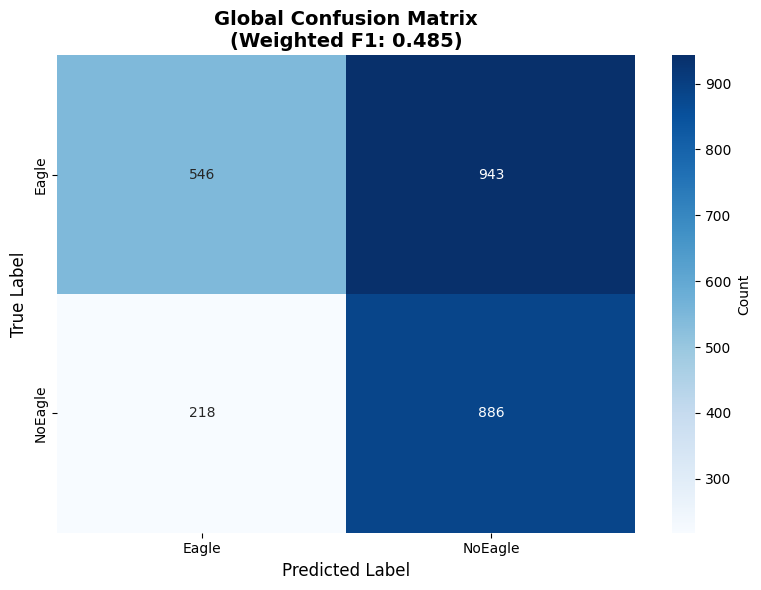

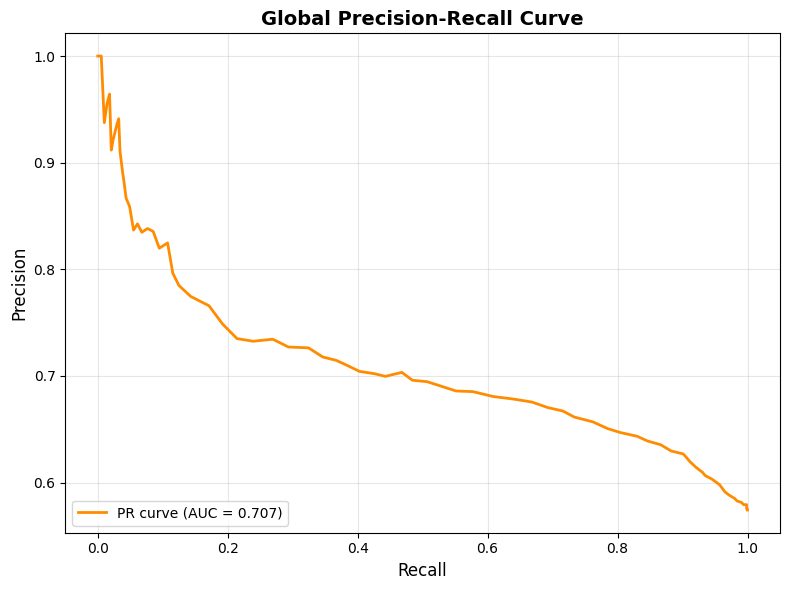

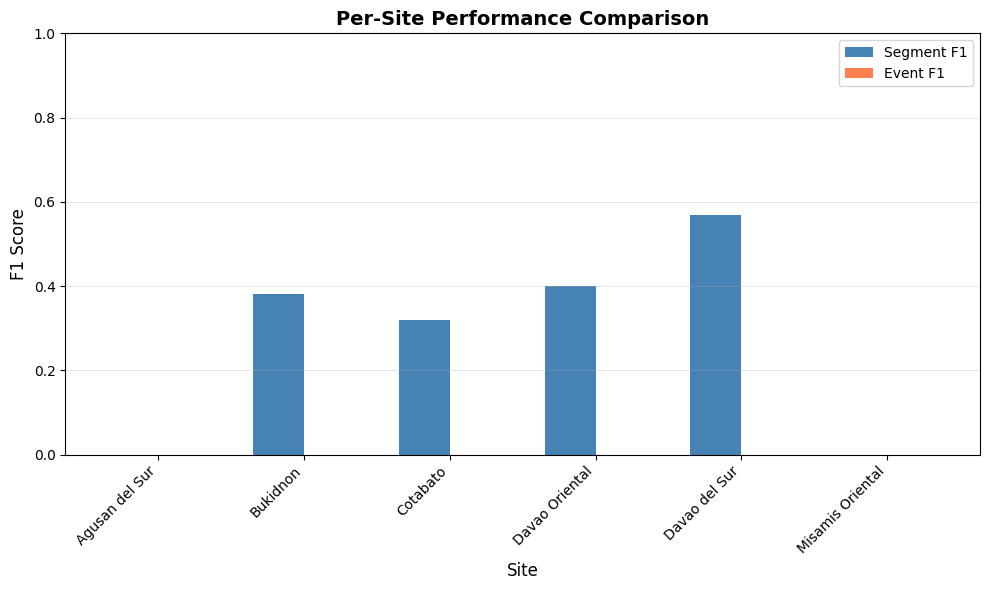


🎉 Analysis Complete!


In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                             precision_recall_curve, average_precision_score, auc)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ===============================
# USER SETTINGS
# ===============================
SEGMENTED_AUDIO_FOLDER = r"D:/_3rd Year Class/1st Sem/Machine Learning/_ForLE/For DataSet/3_SegmentedAudios"

MANIFEST_EAGLE = r"D:/_3rd Year Class/1st Sem/Machine Learning/_ForLE/For DataSet/3_SegmentedAudios/master_manifest_PhilEagle.csv"
MANIFEST_NOEAGLE = r"D:/_3rd Year Class/1st Sem/Machine Learning/_ForLE/For DataSet/3_SegmentedAudios/master_manifest_NoEagle.csv"

ANNOTATION_FOLDER = r"D:/_3rd Year Class/1st Sem/Machine Learning/_ForLE/For DataSet/2_SelectionTables"
OVERLAP_THRESHOLD = 0.1 

# ===============================
# HELPER FUNCTIONS
# ===============================
def extract_audio_features(y, sr):
    if len(y) < sr * 0.5:
        y = np.pad(y, (0, int(sr * 0.5) - len(y)), mode='constant')
    
    features = []
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    features.append(np.mean(mfccs, axis=1))
    features.append(np.std(mfccs, axis=1))
    # Spectral
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(np.mean(spec_cent))
    features.append(np.std(spec_cent))
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features.append(np.mean(spec_bw))
    spec_roll = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features.append(np.mean(spec_roll))
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))
    
    return np.concatenate([np.array(f).flatten() for f in features])

def map_label(label_full):
    """Convert detailed labels to binary Eagle/NoEagle"""
    if pd.isna(label_full):
        return "NoEagle"
    label_str = str(label_full)
    if "NoEagle" in label_str:
        return "NoEagle"
    return "Eagle"

def load_ground_truth_events(annotation_folder):
    """Load ground truth eagle call events from annotation files"""
    gt_events = {}
    if not os.path.exists(annotation_folder): 
        print(f"⚠️ Annotation folder not found: {annotation_folder}")
        return {}
    
    for f in os.listdir(annotation_folder):
        if f.endswith(".txt"):
            base_name = f.split(".Table")[0].split(".txt")[0]
            path = os.path.join(annotation_folder, f)
            try:
                df = pd.read_csv(path, sep="\t", engine="python", comment="#")
                df.columns = [c.strip() for c in df.columns]
                if 'Type' in df.columns:
                    df = df[~df['Type'].astype(str).str.contains("necessar|ambiguous", case=False, na=False)]
                events = []
                for _, row in df.iterrows():
                    events.append({
                        'start': float(row['Begin Time (s)']), 
                        'end': float(row['End Time (s)'])
                    })
                gt_events[base_name] = events
            except Exception as e:
                print(f"⚠️ Error loading {f}: {e}")
                pass
    
    print(f"✅ Loaded ground truth for {len(gt_events)} audio files")
    return gt_events

def calculate_bootstrap_ci(y_true, y_pred, n_iterations=1000, alpha=0.95):
    """Calculate bootstrap confidence interval for F1 score"""
    stats = []
    if len(y_true) < 10: 
        return 0.0, 0.0
    
    for i in range(n_iterations):
        y_true_boot, y_pred_boot = resample(y_true, y_pred, random_state=i)
        if len(np.unique(y_true_boot)) < 2: 
            continue
        score = f1_score(y_true_boot, y_pred_boot, pos_label="Eagle", average='binary')
        stats.append(score)
    
    if not stats: 
        return 0.0, 0.0
    
    p = ((1.0 - alpha) / 2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    return lower, upper

# ===============================
# 1. LOAD & MERGE DATA
# ===============================
print("="*60)
print("🦅 PHILIPPINE EAGLE DETECTION - LOSO VALIDATION")
print("="*60)
print("\n📊 Loading Data...")

try:
    # Load with UTF-8-BOM handling
    df_eagle = pd.read_csv(MANIFEST_EAGLE, encoding='utf-8-sig')
    df_noeagle = pd.read_csv(MANIFEST_NOEAGLE, encoding='utf-8-sig')
    
    # Clean column names
    df_eagle.columns = [c.strip() for c in df_eagle.columns]
    df_noeagle.columns = [c.strip() for c in df_noeagle.columns]
    
    # Concatenate
    manifest = pd.concat([df_eagle, df_noeagle], ignore_index=True)
    
    print(f"   Columns Found: {list(manifest.columns)}")
    
    # Check for location_id column
    if 'location_id' not in manifest.columns:
        print("❌ CRITICAL: 'location_id' missing. Trying fallback...")
        possible_cols = [c for c in manifest.columns if 'loc' in c.lower()]
        if possible_cols:
            print(f"   Found similar column: '{possible_cols[0]}'. Renaming it.")
            manifest.rename(columns={possible_cols[0]: 'location_id'}, inplace=True)
        else:
            print("   ❌ No location column found. Please check CSV.")
            exit()

    print(f"   Eagle Samples: {len(df_eagle)}")
    print(f"   NoEagle Samples: {len(df_noeagle)}")
    print(f"   Total Combined: {len(manifest)}")
    
except Exception as e:
    print(f"❌ Error loading manifests: {e}")
    exit()

# Load ground truth annotations
gt_data = load_ground_truth_events(ANNOTATION_FOLDER)

# ===============================
# 2. FEATURE EXTRACTION
# ===============================
all_features = []
all_labels = []
all_groups = [] 
all_metadata = []
valid_indices = []
failed_files = []

print("\n🎧 Extracting Features from Audio Segments...")

for idx, row in tqdm(manifest.iterrows(), total=len(manifest), desc="Processing"):
    # Get filename
    filename = row.get('segment_filename', '')
    if pd.isna(filename) or filename == '':
        continue
    
    # ROBUST LABEL EXTRACTION
    label_full = row.get('label_full', row.get('label', ''))
    if pd.isna(label_full) or label_full == '':
        continue
    
    label_full = str(label_full).strip()
    
    # ROBUST LOCATION EXTRACTION
    location_id = row.get('location_id', 'Unknown')
    if pd.isna(location_id):
        location_id = 'Unknown'
    location_id = str(location_id).strip()
    
    # --- PATH LOGIC ---
    if "NoEagle" in label_full:
        # Assumes NoEagle files are in "NoEagleAudio" folder
        folder_path = "NoEagleAudio" 
    else:
        # Assumes Eagle files are in Location/Label folder structure
        label_folder = label_full 
        folder_path = os.path.join(location_id, label_folder)
        
    audio_path = os.path.join(SEGMENTED_AUDIO_FOLDER, folder_path, filename)
    
    # Check if file exists
    if not os.path.exists(audio_path):
        failed_files.append(audio_path)
        continue
    
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=None)
        
        # Extract features
        feat = extract_audio_features(y, sr)
        
        # Map to binary label
        lbl = map_label(row.get('label_base', row.get('label', label_full)))
        
        # Store everything
        all_features.append(feat)
        all_labels.append(lbl)
        all_groups.append(location_id)
        
        all_metadata.append({
            'source_audio': row.get('source_audio', ''), 
            'start_time': row.get('segment_start_time', 0.0),
            'end_time': row.get('segment_end_time', 0.0)
        })
        
        valid_indices.append(idx)
        
    except Exception as e:
        failed_files.append(audio_path)
        continue

# Convert to arrays
X = np.array(all_features)
y = np.array(all_labels)
groups = np.array(all_groups)
metadata = np.array(all_metadata)

print(f"\n✅ Feature Extraction Complete!")
print(f"   Successfully loaded: {len(X)} samples")
print(f"   Failed/Missing files: {len(failed_files)}")
print(f"   Features shape: {X.shape}")

if len(failed_files) > 0:
    print(f"\n⚠️ First 5 failed files:")
    for f in failed_files[:5]:
        print(f"   - {f}")

# Verify data
print(f"\n📊 Dataset Summary:")
unique_labels, label_counts = np.unique(y, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    percentage = (count / len(y)) * 100
    print(f"   • {label}: {count} ({percentage:.1f}%)")

unique_groups, group_counts = np.unique(groups, return_counts=True)
print(f"\n📍 Samples by Location:")
for group, count in zip(unique_groups, group_counts):
    percentage = (count / len(groups)) * 100
    print(f"   • {group}: {count} ({percentage:.1f}%)")

# Verify alignment
assert len(X) == len(y) == len(groups) == len(metadata), "❌ Data arrays misaligned!"
print(f"\n✅ Data arrays verified and aligned!")

# Check if we have enough data
if len(X) < 50:
    print("\n❌ ERROR: Not enough samples for training!")
    print(f"   Found only {len(X)} samples. Need at least 50.")
    exit()

# ===============================
# 3. ENCODING & SCALING
# ===============================
print("\n⚙️ Encoding labels and scaling features...")

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"   Label encoding:")
for i, label in enumerate(le.classes_):
    print(f"   {i}: {label}")

if "Eagle" in le.classes_:
    eagle_idx = le.transform(["Eagle"])[0]
else:
    print("❌ Error: No 'Eagle' class found in data!")
    exit()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Preprocessing complete!")

# ===============================
# 4. LOSO CROSS-VALIDATION
# ===============================
print("\n" + "="*60)
print("🚀 STARTING LEAVE-ONE-SITE-OUT VALIDATION")
print("="*60)

logo = LeaveOneGroupOut()
site_metrics = []

# Containers for Global Metrics
y_true_global = []
y_pred_global = []
y_prob_global = []

# Get unique sites
unique_sites = np.unique(groups)
print(f"\n📍 Will test on {len(unique_sites)} sites: {', '.join(unique_sites)}")

for train_idx, test_idx in logo.split(X_scaled, y_encoded, groups=groups):
    test_site = groups[test_idx][0]
    
    # Optional: Skip specific sites
    if test_site == "GeneralForest":
        print(f"\n⏭️  Skipping: {test_site} (marked as general test set)")
        continue 

    print(f"\n" + "-"*60)
    print(f"📍 Testing Site: {test_site}")
    print(f"   Training samples: {len(train_idx)}")
    print(f"   Testing samples: {len(test_idx)}")
    
    # Split data
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    meta_test = metadata[test_idx] 
    
    # Check test set balance
    test_labels = le.inverse_transform(y_test)
    eagle_test = np.sum(test_labels == "Eagle")
    noeagle_test = np.sum(test_labels == "NoEagle")
    print(f"   Test set: {eagle_test} Eagle, {noeagle_test} NoEagle")
    
    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1, 
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, eagle_idx] 
    
    # Segment-level Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=eagle_idx, average='binary')
    
    try: 
        ap = average_precision_score(y_test, y_prob, pos_label=eagle_idx)
    except: 
        ap = 0.0
    
    # Event Reconstruction (Stitching)
    files_to_process = {}
    pred_labels_text = le.inverse_transform(y_pred)
    
    for i, m in enumerate(meta_test):
        fname = m['source_audio'].replace('.wav', '')
        if fname not in files_to_process: 
            files_to_process[fname] = []
        
        is_eagle = (pred_labels_text[i] == "Eagle")
        files_to_process[fname].append({
            'start': m['start_time'], 
            'end': m['end_time'], 
            'is_eagle': is_eagle
        })
    
    # Stitch segments into events
    tp, fp, fn = 0, 0, 0
    
    for fname, segments in files_to_process.items():
        segments.sort(key=lambda x: x['start'])
        
        # Merge consecutive eagle segments
        pred_events = []
        curr = None
        
        for seg in segments:
            if seg['is_eagle']:
                if curr and (seg['start'] - curr['end'] < 0.1): 
                    # Extend current event
                    curr['end'] = seg['end']
                else: 
                    # Start new event
                    if curr: 
                        pred_events.append(curr)
                    curr = {'start': seg['start'], 'end': seg['end']}
            else:
                if curr: 
                    pred_events.append(curr)
                    curr = None
        
        if curr: 
            pred_events.append(curr)
        
        # Compare with ground truth
        real_events = gt_data.get(fname, [])
        matched = set()
        
        for p in pred_events:
            hit = False
            for i_gt, r in enumerate(real_events):
                intersection = max(0, min(p['end'], r['end']) - max(p['start'], r['start']))
                coverage = intersection / (r['end'] - r['start']) if (r['end'] - r['start']) > 0 else 0
                
                if coverage >= OVERLAP_THRESHOLD: 
                    hit = True
                    matched.add(i_gt)
                    break
            
            if hit: 
                tp += 1
            else: 
                fp += 1
        
        fn += len(real_events) - len(matched)
    
    # Event-level metrics
    prec_event = tp/(tp+fp) if (tp+fp)>0 else 0
    rec_event = tp/(tp+fn) if (tp+fn)>0 else 0
    f1_event = 2*(prec_event*rec_event)/(prec_event+rec_event) if (prec_event+rec_event)>0 else 0

    print(f"   🔹 Segment-level F1: {f1:.3f}")
    print(f"   🔹 Event-level F1: {f1_event:.3f} (TP={tp}, FP={fp}, FN={fn})")
    
    # Store results
    site_metrics.append({
        'site': test_site, 
        'seg_acc': acc, 
        'seg_f1': f1, 
        'seg_ap': ap,
        'event_prec': prec_event,
        'event_rec': rec_event,
        'event_f1': f1_event,
        'samples': len(y_test),
        'tp': tp,
        'fp': fp,
        'fn': fn
    })
    
    # Accumulate global predictions
    y_true_global.extend(le.inverse_transform(y_test))
    y_pred_global.extend(le.inverse_transform(y_pred))
    y_prob_global.extend(y_prob)

# ===============================
# 5. FINAL REPORTING
# ===============================
print("\n" + "="*60)
print("📊 FINAL FEASIBILITY REPORT")
print("="*60)

df_res = pd.DataFrame(site_metrics)
print("\n📋 Per-Site Results:")
print(df_res[['site', 'samples', 'seg_f1', 'event_f1']].to_string(index=False))
print("-" * 60)

# Macro average (average across sites)
macro_f1 = df_res['seg_f1'].mean()
macro_event_f1 = df_res['event_f1'].mean()
print(f"\n🏆 Site-Average (Macro) Metrics:")
print(f"   • Segment F1: {macro_f1:.3f}")
print(f"   • Event F1: {macro_event_f1:.3f}")

# Global metrics (weighted by samples)
global_f1 = f1_score(y_true_global, y_pred_global, pos_label="Eagle", average='binary')
global_acc = accuracy_score(y_true_global, y_pred_global)

try:
    global_ap = average_precision_score(
        [1 if y == "Eagle" else 0 for y in y_true_global], 
        y_prob_global
    )
except:
    global_ap = 0.0

print(f"\n🏆 Global (Micro) Metrics:")
print(f"   • Accuracy: {global_acc:.2%}")
print(f"   • F1-Score: {global_f1:.3f} ← MAIN METRIC")
print(f"   • Average Precision: {global_ap:.3f}")

# Bootstrap confidence interval
print("\n🔄 Calculating Bootstrap 95% CI...")
lower, upper = calculate_bootstrap_ci(y_true_global, y_pred_global)
print(f"   F1 Confidence Interval: [{lower:.3f}, {upper:.3f}]")

# Event-level summary
total_tp = df_res['tp'].sum()
total_fp = df_res['fp'].sum()
total_fn = df_res['fn'].sum()
global_event_prec = total_tp/(total_tp+total_fp) if (total_tp+total_fp)>0 else 0
global_event_rec = total_tp/(total_tp+total_fn) if (total_tp+total_fn)>0 else 0
global_event_f1 = 2*(global_event_prec*global_event_rec)/(global_event_prec+global_event_rec) if (global_event_prec+global_event_rec)>0 else 0

print(f"\n🎯 Event Detection Performance:")
print(f"   • Precision: {global_event_prec:.3f}")
print(f"   • Recall: {global_event_rec:.3f}")
print(f"   • F1-Score: {global_event_f1:.3f}")
print(f"   • True Positives: {total_tp}")
print(f"   • False Positives: {total_fp}")
print(f"   • False Negatives: {total_fn}")

# Feasibility assessment
print("\n" + "="*60)
print("🔬 FEASIBILITY ASSESSMENT")
print("="*60)

if global_f1 >= 0.85 and global_event_f1 >= 0.70:
    print("🟢 HIGHLY FEASIBLE - Excellent performance")
    print("   ✅ Ready for real-world deployment")
elif global_f1 >= 0.75 and global_event_f1 >= 0.60:
    print("🟢 FEASIBLE - Good performance")
    print("   ✅ Suitable for deployment with monitoring")
elif global_f1 >= 0.65:
    print("🟡 MODERATELY FEASIBLE - Acceptable performance")
    print("   ⚠️ Consider additional data or feature engineering")
elif global_f1 >= 0.55:
    print("🟠 LIMITED FEASIBILITY - Below target performance")
    print("   ⚠️ Significant improvement needed")
else:
    print("🔴 NOT FEASIBLE - Insufficient performance")
    print("   ❌ Major revision of approach required")

# ===============================
# 6. VISUALIZATIONS
# ===============================
print("\n📊 Generating visualizations...")

# Confusion Matrix
cm = confusion_matrix(y_true_global, y_pred_global, labels=["Eagle", "NoEagle"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Eagle", "NoEagle"], 
            yticklabels=["Eagle", "NoEagle"],
            cbar_kws={'label': 'Count'})
plt.title(f'Global Confusion Matrix\n(Weighted F1: {global_f1:.3f})', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(
    [1 if y == "Eagle" else 0 for y in y_true_global], 
    y_prob_global
)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, 
         label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Global Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Per-site F1 comparison
plt.figure(figsize=(10, 6))
sites = df_res['site'].values
seg_f1s = df_res['seg_f1'].values
event_f1s = df_res['event_f1'].values

x = np.arange(len(sites))
width = 0.35

plt.bar(x - width/2, seg_f1s, width, label='Segment F1', color='steelblue')
plt.bar(x + width/2, event_f1s, width, label='Event F1', color='coral')

plt.xlabel('Site', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Per-Site Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, sites, rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n🎉 Analysis Complete!")
print("="*60)